In [ ]:
from datasetsforecast.m3 import M3

Y_df = M3().load("../data", group="Monthly")[0]
Y_df.sort_values(["unique_id", "ds"], inplace=True)
Y_df

/home/pranav-pc/projects/ts/.venv/lib/python3.12/site-packages/datasetsforecast/m3.py:108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(class_group.freq)


,unique_id,ds,y
0,M1,1990-01-31,2640.0
1,M1,1990-02-28,2640.0
2,M1,1990-03-31,2160.0
3,M1,1990-04-30,4200.0
4,M1,1990-05-31,3360.0
...,...,...,...
167557,M999,1993-10-31,5225.9
167558,M999,1993-11-30,5236.3
167559,M999,1993-12-31,5186.6
167560,M999,1994-01-31,5143.4


In [ ]:
Y_df.unique_id.nunique()

1428

<Axes: ylabel='Frequency'>

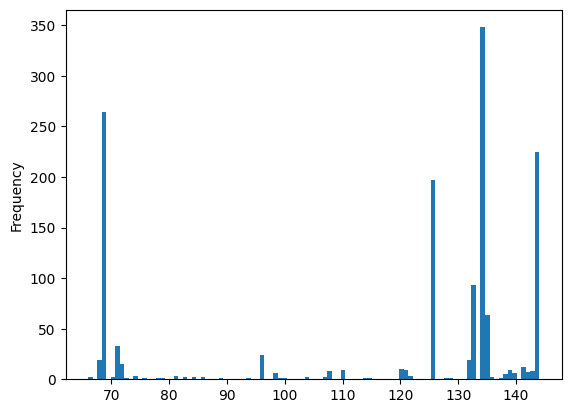

In [ ]:
Y_df.unique_id.value_counts().plot(kind="hist", bins=100)

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


def create_ts_subgroups(df, input_size, horizon, sliding_step):
    """
    Create subgroups from time series data and apply MinMax scaling to each subgroup.
    Returns separate DataFrames for training and testing.

    Parameters:
    df: DataFrame with columns ['unique_id', 'ds', 'y']
    input_size: Number of time steps for input (training)
    horizon: Number of time steps for prediction (testing)
    sliding_step: Step size for sliding window

    Returns:
    train_df: DataFrame with input_size steps
    test_df: DataFrame with horizon steps
    """

    df = df.sort_values(["unique_id", "ds"]).reset_index(drop=True)

    train_rows, test_rows = [], []
    scaler = MinMaxScaler()

    for unique_id in df["unique_id"].unique():
        id_df = df[df["unique_id"] == unique_id]
        n_points = len(id_df)
        window_size = input_size + horizon

        if n_points < window_size:
            continue

        n_windows = ((n_points - window_size) // sliding_step) + 1

        for i in range(n_windows):
            start_idx = i * sliding_step
            end_idx = start_idx + window_size

            if end_idx <= n_points:
                subgroup_name = f"{unique_id}-{i+1}"
                window_df = id_df.iloc[start_idx:end_idx].copy()
                window_df["subgroup"] = subgroup_name

                y_values = window_df["y"].values.reshape(-1, 1)
                scaled_values = scaler.fit_transform(y_values)
                window_df["y_scaled"] = scaled_values.flatten()

                train_rows.append(window_df.iloc[:input_size])  # First input_size rows
                test_rows.append(window_df.iloc[input_size:])  # Remaining horizon rows

    train_df = pd.concat(train_rows, ignore_index=True) if train_rows else pd.DataFrame()
    test_df = pd.concat(test_rows, ignore_index=True) if test_rows else pd.DataFrame()

    return train_df, test_df


# Example usage
input_size = 12 * 5
horizon = 12
sliding_step = 3
season_length = horizon

train_df, test_df = create_ts_subgroups(Y_df, input_size, horizon, sliding_step)

In [ ]:
# train_df = train_df.drop(['y','unique_id'],axis=1).rename(columns={'subgroup':'unique_id', "y_scaled":'y'}).sort_values(['unique_id','ds'])

#### Baseline Models - Classical models for establishing baseline.
- HistoricAverage - 
- Naive
- RandomWalkWithDrift
- SeasonalNaive
- WindowAverage
- SeasonalWindowAverage

#### Exponential Smoothing
- SimpleExponentialSmoothing
- SimpleExponentialSmoothingOptimized	
- SeasonalExponentialSmoothing
- SeasonalExponentialSmoothingOptimized
- Holt
- HoltWinters
- AutoETS
- AutoCES

#### ARIMA Family
- AutoARIMA
- AutoRegressive	

#### Theta Family
- Theta
- OptimizedTheta
- DynamicTheta
- DynamicOptimizedTheta
- AutoTheta

#### Multiple Seasonalities
- MSTL
- AutoMFLES	
- AutoTBATS
#### GARCH and ARCH Models
- GARCH	
- ARCH


#### Sparse or Inttermitent 
- ADIDA
- CrostonClassic	
- CrostonOptimized	
- CrostonSBA
- IMAPA
- TSB

In [ ]:
# Import StatsForecast
from statsforecast.core import StatsForecast

# Import necessary models from the statsforecast library
from statsforecast.models import (
    ADIDA,
    ARCH,
    GARCH,
    IMAPA,
    TSB,
    AutoARIMA,
    AutoCES,
    AutoETS,
    AutoMFLES,
    AutoRegressive,
    AutoTBATS,
    AutoTheta,
    CrostonClassic,
    CrostonOptimized,
    CrostonSBA,
    HistoricAverage,
    Naive,
    RandomWalkWithDrift,
    SeasonalNaive,
    SeasonalWindowAverage,
    WindowAverage,
)

models = [
    HistoricAverage(),
    Naive(),
    RandomWalkWithDrift(),
    SeasonalNaive(season_length=season_length),
    WindowAverage(window_size=season_length),
    # SeasonalWindowAverage(window_size=season_length * 2, season_length=season_length),
    AutoCES(season_length=season_length),
    AutoARIMA(),
    AutoRegressive(lags=season_length),
    AutoTheta(season_length=season_length),
    AutoMFLES(test_size=horizon, season_length=season_length, n_windows=3, step_size=horizon),
    AutoTBATS(season_length=season_length),
    GARCH(),
    ARCH(),
    ADIDA(),
    CrostonClassic(),
    CrostonOptimized(),
    CrostonSBA(),
    IMAPA(),
    TSB(alpha_d=0.2, alpha_p=0.2),
    AutoETS(season_length=season_length),
]

sf = StatsForecast(
    models=models,  # A list of models to be used for forecasting
    freq="ME",
    n_jobs=-1,  # The number of CPU cores to use for parallel execution (-1 means use all available cores)
)

In [ ]:
train_df.drop(["unique_id", "y"], axis=1, inplace=True)

In [ ]:
# import warnings
# from tqdm.auto import tqdm  # Ensure compatibility in Jupyter

# # Suppress specific warnings
# warnings.filterwarnings("ignore", message="Data contains zero or negative values, disabling Box-Cox transformation.")

# batch_size = 350  # Define the batch size

# unique_ids = train_df['subgroup'].unique()
# num_batches = (len(unique_ids) + batch_size - 1) // batch_size  # Calculate total number of batches

# # Use tqdm to create a progress bar for the batch processing
# for i in tqdm(range(num_batches), desc="Processing Batches"):
#     batch_ids = unique_ids[i * batch_size: (i + 1) * batch_size]  # Slice batch of unique_ids

#     # Perform forecasting for the current batch
#     forecast = sf.forecast(df=train_df[train_df.subgroup.isin(batch_ids)], h=horizon, id_col="subgroup",target_col="y_scaled")
#     forecast = forecast.merge(test_df[['y_scaled','subgroup','ds']], on=['subgroup', 'ds'])


#     # Save the current batch's forecast to a CSV file
#     forecast.to_csv(f'forecast_batch_{i + 1}.csv', index=False)

In [ ]:
mae()

In [ ]:
from utilsforecast.losses import mae, mse, smape


def evaluate_cv(df, metrics):
    models = df.columns.drop(["subgroup", "ds", "y_scaled"]).tolist()
    evals = pd.DataFrame()
    for metric in metrics:
        evals[f"best_model_{str(metric.__name__)}"] = metric(
            df, models=models, id_col="subgroup", target_col="y_scaled"
        )[models].idxmin(axis=1)
    return evals

In [ ]:
import glob

file_list = glob.glob("*.csv")
bucket = []
for file in file_list:
    bucket.append(pd.read_csv(file))
forecast_df = pd.concat(bucket)
forecast_df.to_parquet("M3_MONTHLY_FORECAST_DATA.parquet")

evaluate_cv(pd.read_parquet("M3_MONTHLY_FORECAST_DATA.parquet"), [mse, mae, smape]).to_parquet(
    "M3_MONTHLY_METRIC_DATA.parquet"
)

In [ ]:
# forecast_df

In [ ]:
### EDA

In [ ]:
import pandas as pd

forecast_df = pd.read_parquet("M3_MONTHLY_FORECAST_DATA.parquet")

In [ ]:
forecast_df[forecast_df.subgroup == "M1000-1"]

,subgroup,ds,HistoricAverage,Naive,RWD,SeasonalNaive,WindowAverage,CES,AutoARIMA,AutoRegressive,AutoTheta,AutoMFLES,AutoTBATS,"GARCH(1,1)",ARCH(1),ADIDA,CrostonClassic,CrostonOptimized,CrostonSBA,IMAPA,TSB,AutoETS,y_scaled
0,M1000-1,1988-01-31,0.400974,0.573621,0.578278,0.180490,0.417062,0.460119,0.573621,0.521558,0.570393,0.380394,0.550075,0.318185,0.318167,0.498662,0.382461,0.488768,0.363338,0.498662,0.453076,0.570218,0.584216
1,M1000-1,1988-02-29,0.400974,0.573621,0.582934,0.379613,0.417062,0.541094,0.573621,0.523731,0.570393,0.380236,0.531224,-0.115981,-0.115974,0.498662,0.382461,0.488768,0.363338,0.498662,0.453076,0.570218,0.585678
2,M1000-1,1988-03-31,0.400974,0.573621,0.587591,0.375594,0.417062,0.482573,0.573621,0.535521,0.570393,0.380077,0.516927,-0.098822,-0.098817,0.498662,0.382461,0.488768,0.363338,0.498662,0.453076,0.570218,0.671173
3,M1000-1,1988-04-30,0.400974,0.573621,0.592248,0.318232,0.417062,0.484948,0.573621,0.478504,0.570393,0.379919,0.511014,-0.200642,-0.200632,0.498662,0.382461,0.488768,0.363338,0.498662,0.453076,0.570218,0.719766
4,M1000-1,1988-05-31,0.400974,0.573621,0.596905,0.386189,0.417062,0.505542,0.573621,0.469097,0.570393,0.379761,0.515070,0.162579,0.162571,0.498662,0.382461,0.488768,0.363338,0.498662,0.453076,0.570218,0.812569
5,M1000-1,1988-06-30,0.400974,0.573621,0.601562,0.461089,0.417062,0.518640,0.573621,0.478913,0.570393,0.379603,0.528008,-0.431473,-0.431451,0.498662,0.382461,0.488768,0.363338,0.498662,0.453076,0.570218,0.842528
6,M1000-1,1988-07-31,0.400974,0.573621,0.606219,0.351114,0.417062,0.463507,0.573621,0.444000,0.570393,0.379445,0.546361,0.334932,0.334913,0.498662,0.382461,0.488768,0.363338,0.498662,0.453076,0.570218,0.857508
7,M1000-1,1988-08-31,0.400974,0.573621,0.610875,0.491049,0.417062,0.499370,0.573621,0.423771,0.570393,0.379286,0.565212,-0.144548,-0.144540,0.498662,0.382461,0.488768,0.363338,0.498662,0.453076,0.570218,0.875046
8,M1000-1,1988-09-30,0.400974,0.573621,0.615532,0.476799,0.417062,0.470418,0.573621,0.421442,0.570393,0.379128,0.579509,0.059761,0.059757,0.498662,0.382461,0.488768,0.363338,0.498662,0.453076,0.570218,0.844720
9,M1000-1,1988-10-31,0.400974,0.573621,0.620189,0.465108,0.417062,0.508389,0.573621,0.397531,0.570393,0.378970,0.585422,-0.046588,-0.046585,0.498662,0.382461,0.488768,0.363338,0.498662,0.453076,0.570218,0.879065


In [ ]:
eval_df = pd.read_parquet("M3_MONTHLY_METRIC_DATA.parquet")
eval_df[eval_df.apply(lambda x: set(x), axis=1).map(len) > 2]

,best_model_mse,best_model_mae,best_model_smape
10,AutoTheta,AutoARIMA,AutoETS
295,CrostonSBA,CrostonClassic,WindowAverage
325,ADIDA,WindowAverage,CrostonOptimized
344,CrostonClassic,CrostonSBA,TSB
345,RWD,AutoETS,CrostonClassic
...,...,...,...
22322,ADIDA,WindowAverage,TSB
22459,AutoETS,WindowAverage,TSB
22537,AutoRegressive,CES,AutoTBATS
22561,AutoRegressive,CrostonClassic,HistoricAverage


In [ ]:
eval_df["group"] = eval_df.subgroup.str.split("-").apply(lambda x: x[0])
eval_df["suffix"] = eval_df.subgroup.str.split("-").apply(lambda x: x[1])

AttributeError: 'DataFrame' object has no attribute 'subgroup'

In [ ]:
eval_df.groupby(["group"])["best_model_smape"].apply(lambda x: set(x)).reset_index()

,group,best_model_smape
0,M1121,"{CES, Naive, AutoARIMA, CrostonClassic, Season..."
1,M1122,"{CES, Naive, AutoARIMA, CrostonClassic, Season..."
2,M1123,"{AutoARIMA, CES, Naive, CrostonClassic, Crosto..."
3,M1124,"{CES, AutoARIMA, Naive, CrostonClassic, Crosto..."
4,M1125,"{CES, AutoARIMA, Naive, CrostonClassic, Crosto..."
...,...,...
84,M700,"{CES, Naive, AutoARIMA, CrostonClassic, Season..."
85,M701,"{CES, Naive, AutoARIMA, CrostonClassic, Crosto..."
86,M702,"{CES, Naive, AutoARIMA, CrostonClassic, Crosto..."
87,M703,"{CES, AutoARIMA, Naive, CrostonClassic, Crosto..."


In [ ]:
eval_df.subgroup

0        M497-10
1        M497-10
2        M497-10
3        M497-10
4        M497-10
          ...   
22686     M363-6
22687     M363-6
22688     M363-6
22689     M363-6
22690     M363-6
Name: subgroup, Length: 22691, dtype: object

In [ ]:
Y_df[Y_df.unique_id == "M1000"].head(30)

,unique_id,ds,y
205,M1000,1983-01-31,3705.4
206,M1000,1983-02-28,3726.0
207,M1000,1983-03-31,3692.0
208,M1000,1983-04-30,3721.6
209,M1000,1983-05-31,3681.0
210,M1000,1983-06-30,3684.6
211,M1000,1983-07-31,3730.6
212,M1000,1983-08-31,3759.4
213,M1000,1983-09-30,3782.8
214,M1000,1983-10-31,3806.0


In [ ]:
train_df

,ds,subgroup,y_scaled
0,1983-01-31,M1000-1,0.298867
1,1983-02-28,M1000-1,0.336500
2,1983-03-31,M1000-1,0.274388
3,1983-04-30,M1000-1,0.328462
4,1983-05-31,M1000-1,0.254293
...,...,...,...
1361455,1992-08-31,M999-21,0.922721
1361456,1992-09-30,M999-21,0.933704
1361457,1992-10-31,M999-21,0.930263
1361458,1992-11-30,M999-21,0.878523


In [ ]:
eval_df_counts = pd.DataFrame()
eval_df_counts["best_model_mse"] = eval_df.best_model_mse.value_counts()
eval_df_counts["best_model_mae"] = eval_df.best_model_mae.value_counts()
eval_df_counts["best_model_smape"] = eval_df.best_model_smape.value_counts()
eval_df_counts

,best_model_mse,best_model_mae,best_model_smape
best_model_mse,,,
AutoTBATS,2955,2948,2872.0
CES,2772,2740,2572.0
AutoMFLES,2412,2369,2292.0
AutoRegressive,2329,2319,2488.0
AutoETS,1976,1907,1888.0
RWD,1813,1811,1792.0
AutoTheta,1423,1442,1411.0
SeasonalNaive,1259,1325,1291.0
AutoARIMA,1004,1060,1071.0


In [ ]:
# train_df.to_parquet('M3_MONTHLY_PROCESSED_DATA.parquet',index=False)

In [ ]:
df_processed = pd.read_parquet("M3_MONTHLY_PROCESSED_DATA.parquet")

In [ ]:
df_processed["subgroup"].str.split("-")

0          [M1000, 1]
1          [M1000, 1]
2          [M1000, 1]
3          [M1000, 1]
4          [M1000, 1]
              ...    
1361455    [M999, 21]
1361456    [M999, 21]
1361457    [M999, 21]
1361458    [M999, 21]
1361459    [M999, 21]
Name: subgroup, Length: 1361460, dtype: object

In [ ]:
eval_df

,best_model_mse,best_model_mae,best_model_smape
0,RWD,RWD,RWD
1,RWD,RWD,RWD
2,AutoMFLES,AutoMFLES,AutoMFLES
3,ADIDA,ADIDA,ADIDA
4,WindowAverage,WindowAverage,WindowAverage
...,...,...,...
22686,RWD,AutoTBATS,AutoTBATS
22687,AutoARIMA,AutoARIMA,AutoARIMA
22688,RWD,RWD,RWD
22689,CES,CES,CES
